# Phase shift analysis

## 0. Imports

In [1]:
import sys
sys.path.append("../")
from surface import *
from source import *
from model import *

import matplotlib.pyplot as plt

## 1. Create Models

In [2]:
# surface
surf = Surface(origin=(0, 0), dims=(101, 101), fs=100)
surf.gen_flat(-10)

# sources
ss = []
n = 40
xs = np.linspace(0, 10000, n)
for x in xs:
    source = Source(1e-9, 0.5e-6, (x, 5050, 25000))
    source.chirp(9e6, 1e6)
    ss.append(source)

# models
ms = []
for i, s in enumerate(ss):
    print(f"Generating: {i+1}/{len(ss)} ({round(100*((i+1)/len(ss)), 1)}%)", end="     \r")
    model = Model(surf, s)
    model.set_target((5050, 5050, -200))
    model.gen_raypaths() 
    ms.append(model)

## 2. Compute Doppler Shift
### Doppler value from sim

In [3]:
# compute doppler shifts
for i, m in enumerate(ms):
    print(f"{i+1}/{len(ms)}", end="   \r")
    m.comp_dopplers()
# pull index of max transmittance per model
trs = [np.argmax([m.raypaths[i].tr for i in range(len(m.raypaths))]) for m in ms]
# grab doppler shift for each index
dopplers = [m.dopplers[t] for t, m in zip(trs, ms)]
relvels = [m.relvels[t] for t, m in zip(trs, ms)]

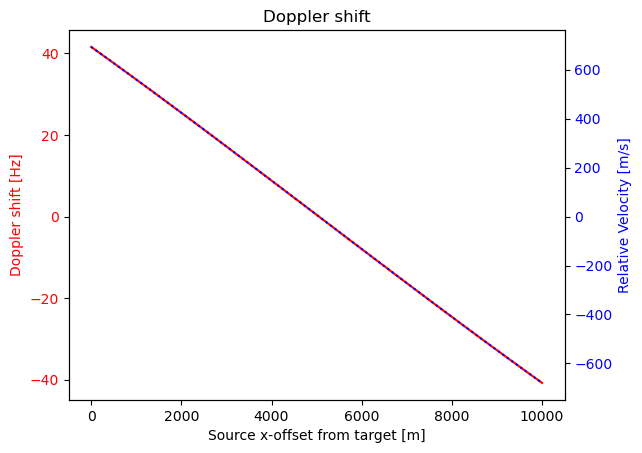

In [4]:
fig, ax1 = plt.subplots()  
ax1.plot(xs, dopplers, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
ax1.set_xlabel("Source x-offset from target [m]")
ax1.set_ylabel("Doppler shift [Hz]", color='red')
ax2 = ax1.twinx() 
ax2.set_ylabel('Relative Velocity [m/s]', color = 'blue') 
ax2.plot(xs, relvels, color = 'blue', linestyle=":") 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
plt.title("Doppler shift")
plt.show()

### Doppler value according to focusing

In [5]:
dt = (10000 / 200) / (ss[0].speed)
# using velocities in ice
f_d = (-2 / ss[0].lam) * (ms[0].c1 + ms[0].nu2 * ms[0].c2)
print(f_d)
# using spacecraft velocity
rair = np.array([m.raypaths[t].mags[0] for t, m in zip(trs, ms)])
rice = np.array([m.raypaths[t].mags[1] for t, m in zip(trs, ms)])
f_d = (-2 / ss[0].lam) * ((np.roll(rair, 1)-rair) / dt + ms[0].nu2 * (np.roll(rice, 1)-rice) / dt)

-2170571428.571429


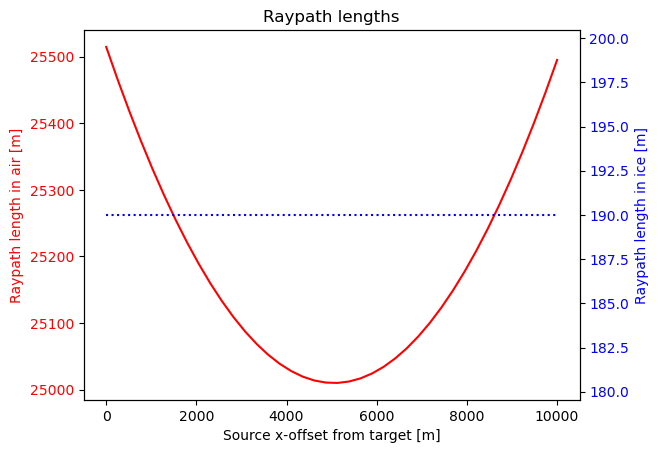

In [6]:
fig, ax1 = plt.subplots()  
ax1.plot(xs, rair, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
ax1.set_xlabel("Source x-offset from target [m]")
ax1.set_ylabel("Raypath length in air [m]", color='red')
ax2 = ax1.twinx() 
ax2.set_ylabel('Raypath length in ice [m]', color = 'blue') 
ax2.plot(xs, rice, color = 'blue', linestyle=":") 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
plt.title("Raypath lengths")
plt.show()

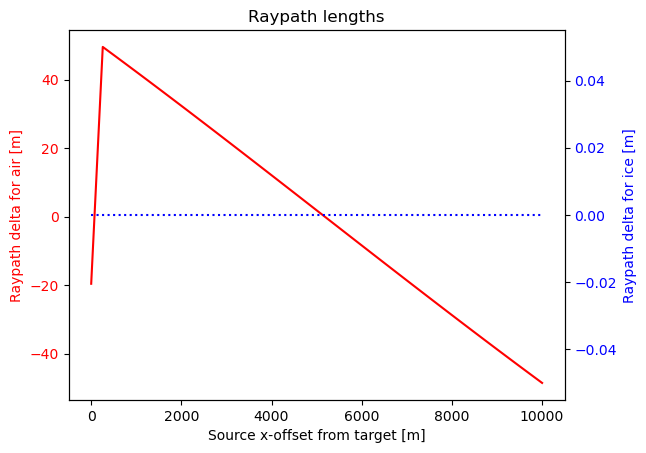

In [7]:
fig, ax1 = plt.subplots()  
ax1.plot(xs, np.roll(rair, 1)-rair, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
ax1.set_xlabel("Source x-offset from target [m]")
ax1.set_ylabel("Raypath delta for air [m]", color='red')
ax2 = ax1.twinx() 
ax2.set_ylabel('Raypath delta for ice [m]', color = 'blue') 
ax2.plot(xs, np.roll(rice, 1)-rice, color = 'blue', linestyle=":") 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
plt.title("Raypath lengths")
plt.show()

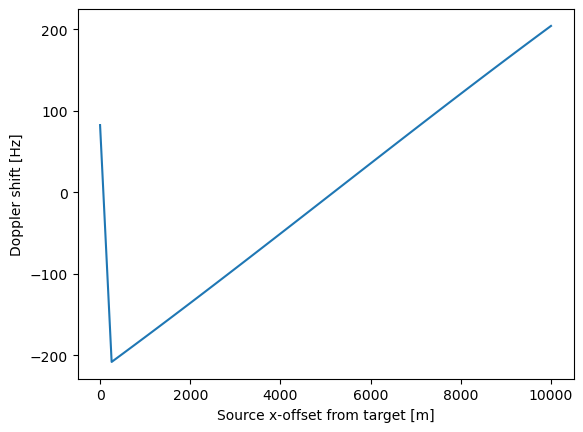

In [8]:
plt.plot(xs, f_d)
plt.xlabel("Source x-offset from target [m]")
plt.ylabel("Doppler shift [Hz]")
plt.show()

## 3. Compute Phase Shift

In [9]:
R_0s = np.array([sum(m.raypaths[t].mags) for t, m in zip(trs, ms)])
phase = -1 * (1 + np.array(relvels)) * (4 * np.pi * (1/ss[0].lam)) * R_0s 

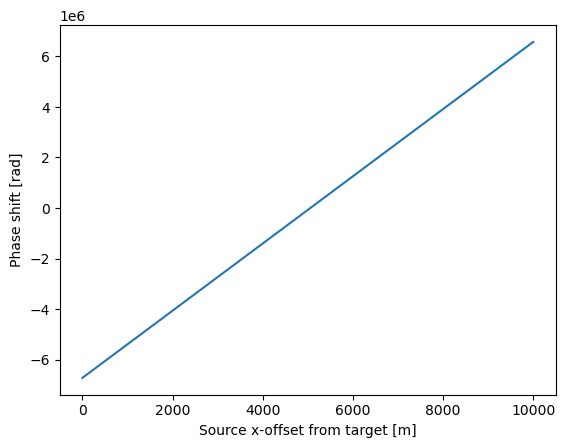

In [10]:
plt.plot(xs, phase)
plt.xlabel("Source x-offset from target [m]")
plt.ylabel("Phase shift [rad]")
plt.show()

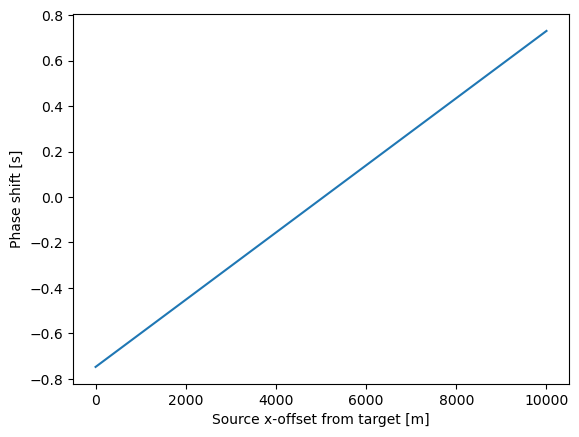

In [11]:
plt.plot(xs, (phase*(1/ss[0].f0)))
plt.xlabel("Source x-offset from target [m]")
plt.ylabel("Phase shift [s]")
plt.show()